## Kernels

Definition of the kernels: https://en.wikipedia.org/wiki/Kernel_(statistics)

There are many choices of kernels for locally weighted regression. The idea is to have a function with one local maximum that has a compact support.

1.   The Exponential (Gaussian) Kernel

$$ K(x):= e^{-\frac{\|x\|^2}{2\tau}}$$


2.   The Tricubic Kernel

$$ K(x):=\begin{cases}
(1-\|x\|^3)^3 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

3.   The Epanechnikov Kernel

$$ K(x):=\begin{cases}
\frac{3}{4}(1-\|x\|^2) \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$

4.   The Quartic Kernel

$$ K(x):=\begin{cases}
\frac{15}{16}(1-\|x\|^2)^2 \;\;\;if \;\;\; \|x\|<1 \\
0 \;\;\; \text{otherwise}
\end{cases}
$$


In [1]:
# this block of code imports graphical libraries for plotting graphs with high resolution
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [46]:
# Libraries of functions need to be imported
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from scipy import linalg
from scipy.interpolate import interp1d
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [11]:
# Gaussian Template
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))
# Tricubic Template
def Tricubic(x):
  return np.where(np.abs(x)>1,0,(1-np.abs(x)**3)**3)
# Epanechnikov Template
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))
# Quartic Template
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2)

In [12]:
def kernel_function(xi,x0,kern, tau):
    return kern((xi - x0)/(2*tau))

In [20]:
def weights_matrix(x,kern,tau):
  n = len(x)
  return np.array([kernel_function(x,x[i],kern,tau) for i in range(n)])

### 1-D Applications

Reference: https://xavierbourretsicotte.github.io/loess.html

In [41]:
def lowess(x, y, kern, tau=0.05):
    lm = linear_model.LinearRegression()
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # tau is a hyper-parameter
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function
    #Looping through all x-points

    w = weights_matrix(x,kern,tau)

    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        lm.fit(np.diag(w[:,i]).dot(x.reshape(-1,1)),np.diag(w[:,i]).dot(y.reshape(-1,1)))
        yest[i] = lm.predict(x[i].reshape(1,-1)).squeeze()

    return yest

## Another Implementation - A Theory-based Robust Approach

### Gramfort's Approach

The idea is based on the following references:

- William S. Cleveland: "Robust locally weighted regression and smoothing
scatterplots", Journal of the American Statistical Association, December 1979,
volume 74, number 368, pp. 829-836.

- William S. Cleveland and Susan J. Devlin: "Locally weighted regression: An
approach to regression analysis by local fitting", Journal of the American
Statistical Association, September 1988, volume 83, number 403, pp. 596-610.

The main idea is to perform a local linear regression in a neighborhood of k observations close by and then apply an iteration to rescale the weights based on the residuals; this step is argued to yield a more robust model.

In [15]:
# example by Alex Gramfort https://gist.github.com/agramfort

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(np.ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

In [7]:
#Initializing noisy non linear data
x = np.linspace(0,4,400)
noise = np.random.normal(loc = 0, scale = .8, size = 400)
y = np.sin(x**2 * 1.5 * np.pi )
y_noise = y + noise

In [8]:

xlr = x.reshape(-1,1)
y_noiselr = y_noise.reshape(-1,1)
lm = linear_model.LinearRegression()
lm.fit(x.reshape(-1,1),y_noise)
# we want to compare with linear regression
yhat_lr = lm.predict(xlr)

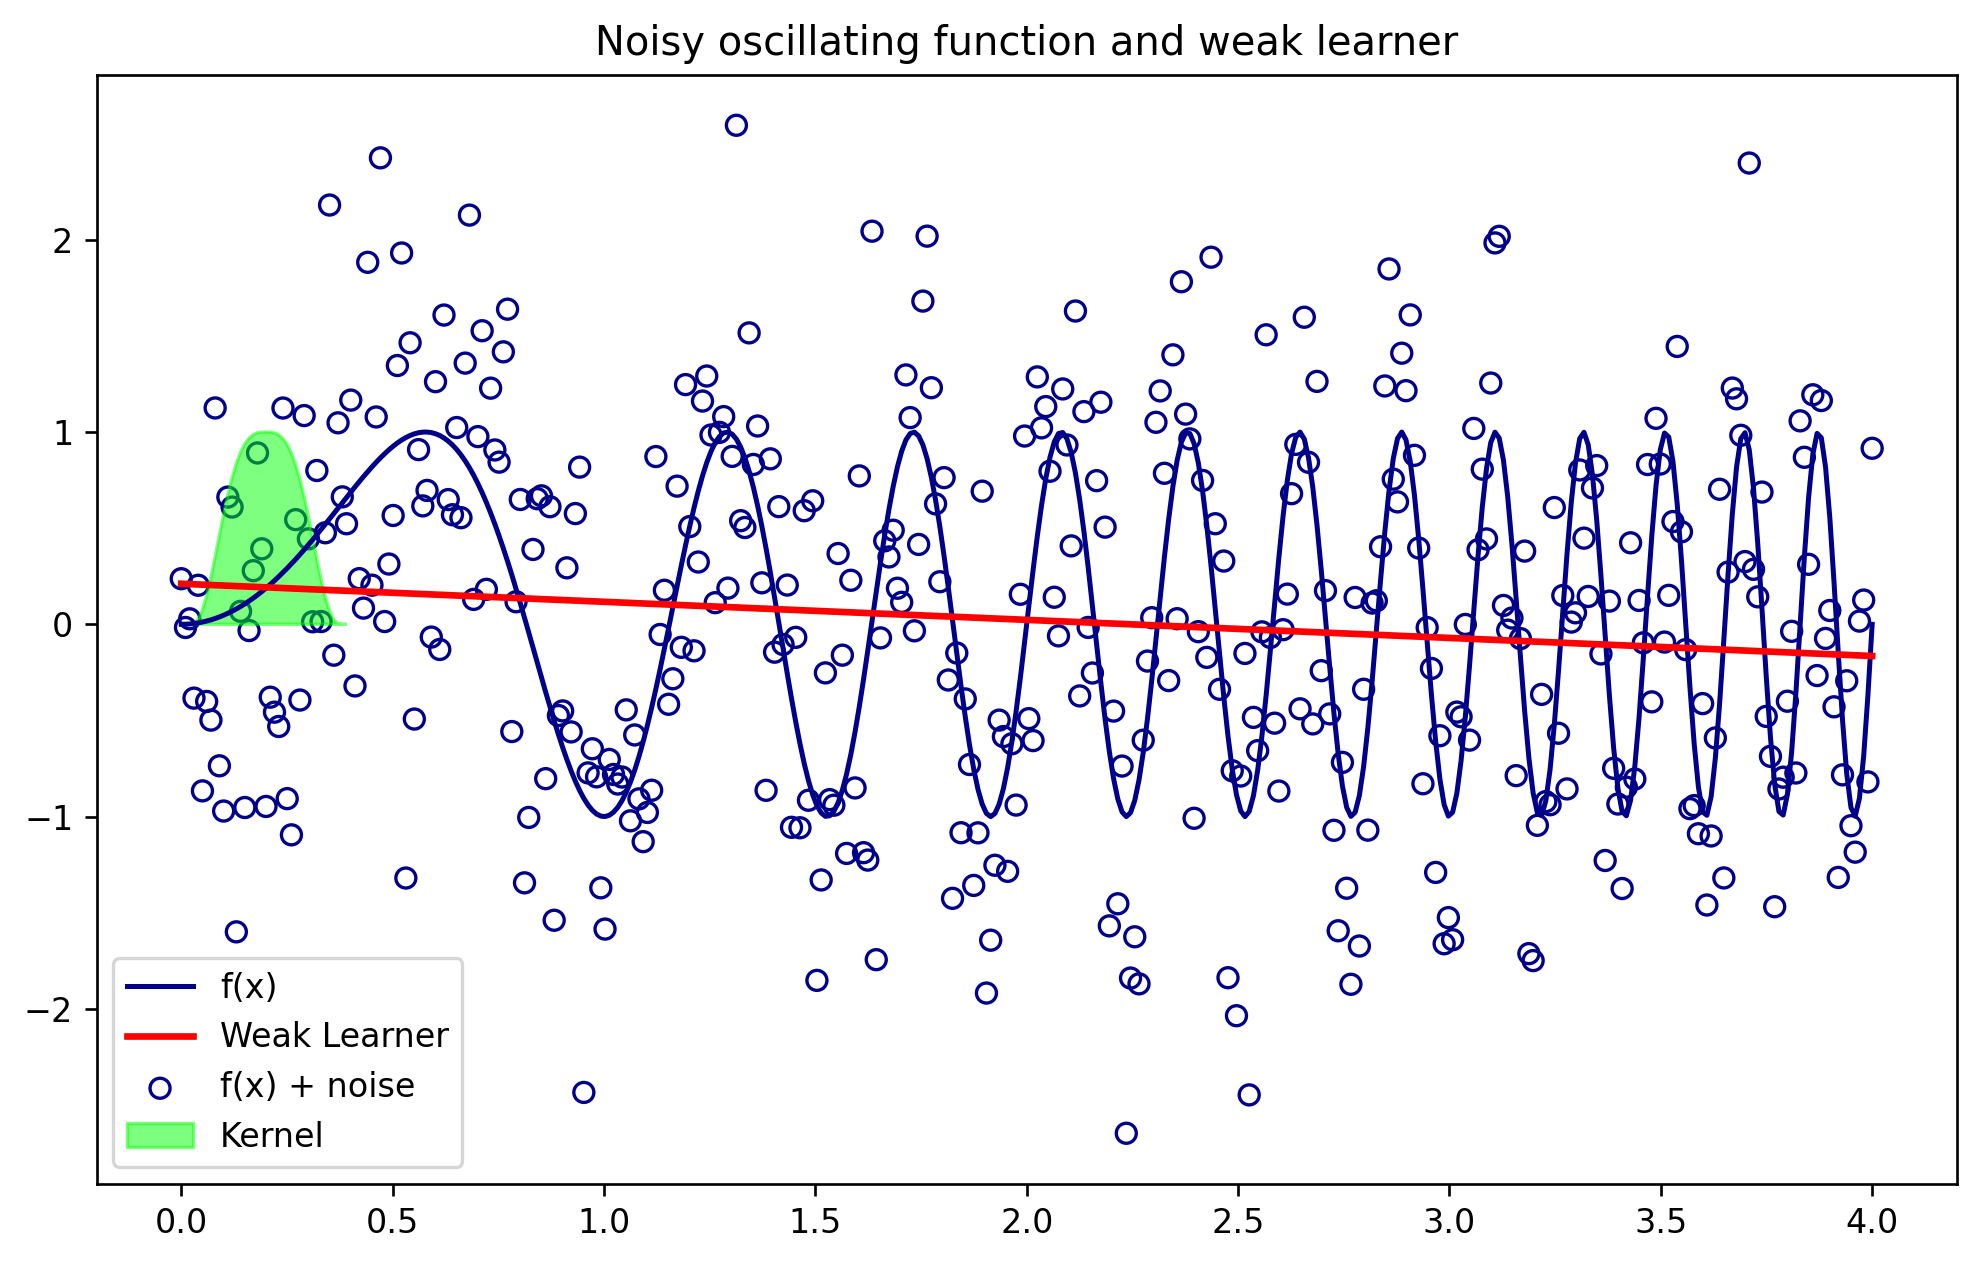

In [16]:
#Plotting the noisy data and the kernell at around x = 0.2
plt.figure(figsize=(10,6))
plt.plot(x,y,color = 'darkblue', label = 'f(x)')
plt.plot(xlr,yhat_lr,color='red',lw=2,label = 'Weak Learner')
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'f(x) + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,Tricubic,.09), color = 'lime', alpha = .5, label = 'Kernel')
plt.legend()
plt.title('Noisy oscillating function and weak learner')
plt.show()

In [42]:
## here is where we make predictions with our kernel
tau = 0.05

yhat_kern = lowess(x,y,Tricubic,tau)

f = 0.02
yest = lowess_ag(x, y, f=f, iter=3)

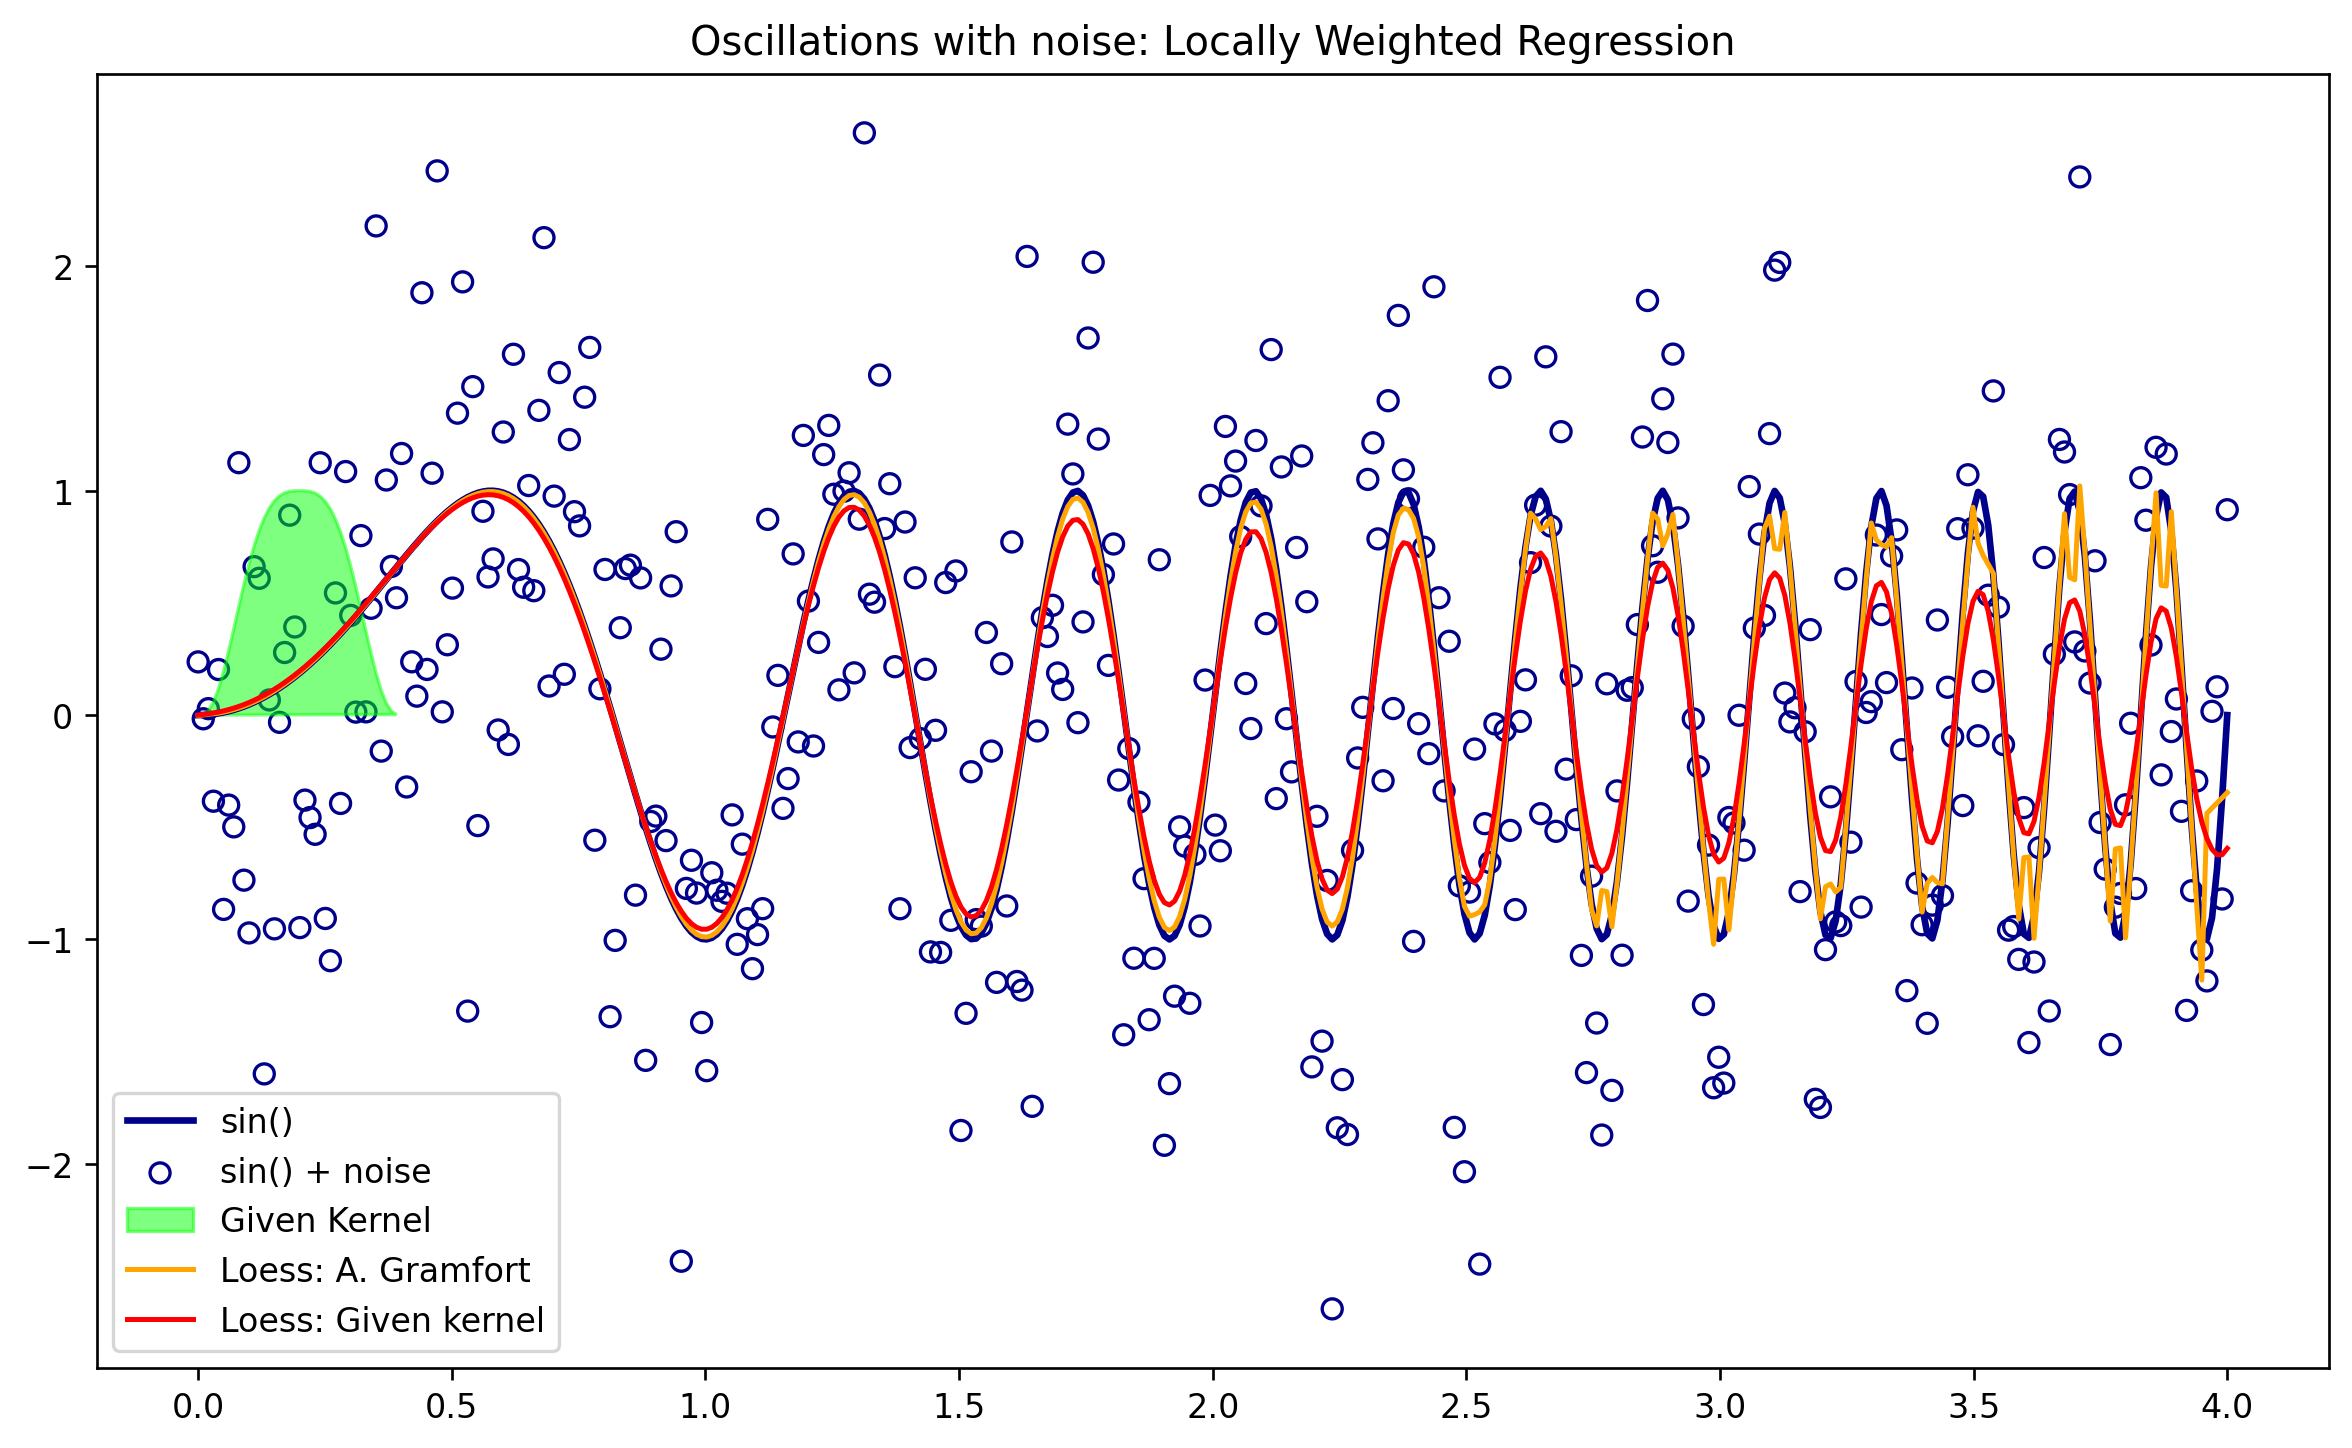

In [43]:
plt.figure(figsize=(12,7))
plt.plot(x,y,color = 'darkblue', label = 'sin()',lw=2)
plt.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue', label = 'sin() + noise')
plt.fill(x[:40],kernel_function(x[:40],0.2,Tricubic,0.1), color = 'lime', alpha = .5, label = 'Given Kernel')
plt.plot(x,yest,color = 'orange', label = 'Loess: A. Gramfort')
plt.plot(x,yhat_kern,color = 'red', label = 'Loess: Given kernel')
plt.legend()
plt.title('Oscillations with noise: Locally Weighted Regression')
plt.show()

### Applications with multiple input variables

In [44]:
def dist(u,v):
  D = []
  if len(v.shape)==1:
    v = v.reshape(1,-1)
  # we would like all the pairwise combinations if u and v are matrices
  # we could avoid two for loops if we consider broadcasting
  for rowj in v:
    D.append(np.sqrt(np.sum((u-rowj)**2,axis=1)))
  return np.array(D).T

In [45]:
def weight_function(u,v,kern=Gaussian,tau=0.5):
    return kern(dist(u,v)/(2*tau))

In [47]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau

    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_
        lm = linear_model.Ridge(alpha=0.001)
        w = weight_function(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w)@(x.reshape(-1,1)),np.diag(w)@(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[:,i])@x,np.diag(w[:,i])@y)
            yest_test[i] = lm.predict(x_new[i].reshape(1,-1))
        return yest_test

In [48]:
model = Lowess(kernel=Epanechnikov,tau=0.02)